## Motivation

If you look at results of a big machine learning competition, you will most likely find that the top results are achieved by an ensemble of models rather than a single model. For instance, the top-scoring single model architecture at ILSVRC2015 is on place 13. Places 1–12 are taken by various ensembles.

I haven’t seen a tutorial or documentation on how to use multiple neural networks in an ensemble, so I decided to make a practical guide on this topic.

![](https://miro.medium.com/max/1400/1*fy-6esoTWsTutld4fdSyCQ.png)

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os
import seaborn as sns
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,  Dropout, BatchNormalization, LeakyReLU,Input
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets


Using TensorFlow backend.


# TPU Configuration


In [2]:


# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 2020
seed_everything(seed)
print("REPLICAS: ", strategy.num_replicas_in_sync)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
AUTO = tf.data.experimental.AUTOTUNE


Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# Configuration
EPOCHS = 35
BATCH_SIZE = 6 * strategy.num_replicas_in_sync
IMG_SIZE = 768
print(BATCH_SIZE)

48


## Load Data and perform test train split

In [4]:

def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

train_paths = train.image_id.apply(format_path).values
test_paths = test.image_id.apply(format_path).values
train_labels = train.loc[:, 'healthy':].values
SPLIT_VALIDATION =True
if SPLIT_VALIDATION:
    train_paths, valid_paths, train_labels, valid_labels =train_test_split(train_paths, train_labels, test_size=0.02, random_state=seed)

def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 0.9)
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label


In [5]:
train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
# train_dataset_1 = (
# tf.data.Dataset
#     .from_tensor_slices((train_paths, train_labels))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .cache()
#     .map(data_augment, num_parallel_calls=AUTO)
#     .repeat()
#     .shuffle(512)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

    

Learning rate schedule: 0.0001 to 0.0004 to 0.000104


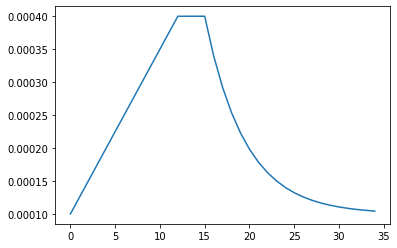

In [6]:


LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 12
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))



## EfficientNet

EfficientNet, which not only focuses on improving the accuracy, but also the efficiency of models.

### What does scaling mean in the context of CNNs?

There are three scaling dimensions of a CNN: depth, width, and resolution. Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN. The figure below(from the paper itself) will give you a clear idea of what scaling means across different dimensions. We will discuss these in detail as well.

![](https://miro.medium.com/max/1400/1*xQCVt1tFWe7XNWVEmC6hGQ.png)

EfficientNet Architecture

Scaling doesn’t change the layer operations, hence it is better to first have a good baseline network and then scale it along different dimensions using the proposed compound scaling. The authors obtained their base network by doing a Neural Architecture Search (NAS) that optimizes for both accuracy and FLOPS. The architecture is similar to M-NASNet as it has been found using the similar search space. The network layers/blocks are as shown below:
![](https://miro.medium.com/max/1400/1*OpvSpqMP61IO_9cp4mAXnA.png)

In [7]:
import tensorflow as tf

from keras.models import Model
from tensorflow import keras
!pip install -q efficientnet
import efficientnet.tfkeras as efn



with strategy.scope():    
    efficient_net = efn.EfficientNetB7(
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    weights='imagenet',
                    include_top=False
                    )
    x = efficient_net.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    model =  keras.Model(inputs = efficient_net.input,outputs=x)
    model.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

258441216/258434480 [==============================] - 3s 0us/step


In [8]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset if SPLIT_VALIDATION else None,
)


Train for 37 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/35
37/37 [==============================] - 422s 11s/step - loss: 0.8570 - accuracy: 0.7100 - val_loss: 0.7310 - val_accuracy: 0.7297

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 2/35
37/37 [==============================] - 41s 1s/step - loss: 0.3811 - accuracy: 0.8806 - val_loss: 0.2566 - val_accuracy: 0.8919

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 3/35
37/37 [==============================] - 40s 1s/step - loss: 0.3105 - accuracy: 0.9009 - val_loss: 0.1284 - val_accuracy: 0.9459

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 4/35
37/37 [==============================] - 40s 1s/step - loss: 0.2432 - accuracy: 0.9251 - val_loss: 0.2641 - val_accuracy: 0.8919

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 5/35
37

In [9]:
predict= model.predict(test_dataset)

# prediction = np.ndarray(shape = (test.shape[0],4), dtype = np.float32)
# for row in range(test.shape[0]):
#     for col in range(4):
#         if predict[row][col] == max(predict[row]):
#             prediction[row][col] = 1
#         else:
#             prediction[row][col] = 0
            
prediction = pd.DataFrame(predict)
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df = pd.concat([test.image_id, prediction], axis = 1)

df.to_csv('effi_submission.csv', index = False)
df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.383620e-04,7.273175e-05,9.997773e-01,1.165818e-05
1,Test_1,8.223471e-08,4.283033e-07,9.999995e-01,3.074289e-08
2,Test_2,2.720899e-06,4.448625e-06,4.184871e-07,9.999924e-01
3,Test_3,9.999863e-01,1.683302e-07,1.096132e-05,2.593581e-06
4,Test_4,1.275523e-05,6.466059e-05,9.999192e-01,3.484726e-06
...,...,...,...,...,...
1816,Test_1816,1.221290e-06,3.023820e-06,9.999933e-01,2.416008e-06
1817,Test_1817,3.834428e-08,1.748531e-04,5.915035e-11,9.998252e-01
1818,Test_1818,6.883852e-07,1.398088e-06,9.999977e-01,7.714485e-08
1819,Test_1819,9.999968e-01,2.595357e-06,4.295934e-07,1.427688e-07


# DenseNet 201

Recent work has shown that convolutional networks can be substantially deeper, more accurate, and efficient to train if they contain shorter connections between layers close to the input and those close to the output. In this paper, we embrace this observation and introduce the Dense Convolutional Network (DenseNet), which connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections — one between each layer and its subsequent layer — our network has L(L+1)/ 2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.
DenseNet architecture is given below
![](https://miro.medium.com/max/1400/1*gAGIm5uaaUukJOSzMW6saQ.jpeg)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
from keras.models import Model
from tensorflow import keras
with strategy.scope():    
    Dense_net = DenseNet201(
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    weights='imagenet',
                    include_top=False
                    )
    x = Dense_net.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    model =  keras.Model(inputs = Dense_net.input,outputs=x)
    model.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

74842112/74836368 [==============================] - 1s 0us/step


In [11]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset if SPLIT_VALIDATION else None,
)

Train for 37 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/35
37/37 [==============================] - 419s 11s/step - loss: 0.6265 - accuracy: 0.7635 - val_loss: 1.5909 - val_accuracy: 0.3784

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 2/35
37/37 [==============================] - 25s 679ms/step - loss: 0.3194 - accuracy: 0.8885 - val_loss: 1.0450 - val_accuracy: 0.5676

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 3/35
37/37 [==============================] - 25s 681ms/step - loss: 0.2288 - accuracy: 0.9217 - val_loss: 0.3499 - val_accuracy: 0.9189

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 4/35
37/37 [==============================] - 25s 678ms/step - loss: 0.1771 - accuracy: 0.9437 - val_loss: 0.1489 - val_accuracy: 0.9459

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002.
Epoc

In [12]:
predict= model.predict(test_dataset)

# prediction = np.ndarray(shape = (test.shape[0],4), dtype = np.float32)
# for row in range(test.shape[0]):
#     for col in range(4):
#         if predict[row][col] == max(predict[row]):
#             prediction[row][col] = 1
#         else:
#             prediction[row][col] = 0
            
prediction = pd.DataFrame(predict)
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df_dense = pd.concat([test.image_id, prediction], axis = 1)

df_dense.to_csv('dense_submission.csv', index = False)
df_dense

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,6.548931e-06,0.015685,0.984202,1.059167e-04
1,Test_1,3.269162e-06,0.000969,0.999026,2.555017e-06
2,Test_2,5.171888e-06,0.000027,0.000006,9.999614e-01
3,Test_3,9.930336e-01,0.000018,0.004644,2.304812e-03
4,Test_4,3.594242e-07,0.043991,0.956007,9.214993e-07
...,...,...,...,...,...
1816,Test_1816,1.185579e-07,0.001561,0.998431,8.133044e-06
1817,Test_1817,4.044929e-03,0.012104,0.000167,9.836838e-01
1818,Test_1818,1.872135e-04,0.119130,0.880608,7.460907e-05
1819,Test_1819,9.994660e-01,0.000037,0.000004,4.935252e-04


# ResNet152
ResNet introduces skip connection (or shortcut connection) to fit the input from the previous layer to the next layer without any modification of the input. Skip connection enables to have deeper network and finally ResNet becomes the Winner of ILSVRC 2015 in image classification, detection, and localization, as well as Winner of MS COCO 2015 detection, and segmentation. This is a 2016 CVPR paper with more than 19000 citations.

Skip / Shortcut Connection in Residual Network (ResNet)

To solve the problem of vanishing/exploding gradients, a skip / shortcut connection is added to add the input x to the output after few weight layers as below:
![](https://miro.medium.com/max/894/1*rbhjv7ZdAgXM2MlBUL5Mmw.png)

Hence, the output H(x)= F(x) + x. The weight layers actually is to learn a kind of residual mapping: F(x)=H(x)-x.

Even if there is vanishing gradient for the weight layers, we always still have the identity x to transfer back to earlier layers.
Resnet Architecture:
![](https://miro.medium.com/max/2000/1*6hF97Upuqg_LdsqWY6n_wg.png)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
from keras.models import Model
from tensorflow import keras
with strategy.scope():
    efficient_net = efn.EfficientNetB5(
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    weights='imagenet',
                    include_top=False
                    )
    x = efficient_net.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    model =  keras.Model(inputs = efficient_net.input,outputs=x)
    
#     Res_net = ResNet152V2(
#                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#                     weights='imagenet',
#                     include_top=False
#                     )
#     x = Res_net.output
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(4, activation='softmax')(x)
#     model =  keras.Model(inputs = Res_net.input,outputs=x)

    model.compile(loss="categorical_crossentropy", optimizer= 'adam', metrics=["accuracy"])

115515392/115515256 [==============================] - 1s 0us/step


In [14]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset if SPLIT_VALIDATION else None,
)

Train for 37 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/35
37/37 [==============================] - 272s 7s/step - loss: 0.7801 - accuracy: 0.7494 - val_loss: 0.6714 - val_accuracy: 0.8108

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 2/35
37/37 [==============================] - 24s 655ms/step - loss: 0.3669 - accuracy: 0.8733 - val_loss: 0.2500 - val_accuracy: 0.9459

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 3/35
37/37 [==============================] - 24s 652ms/step - loss: 0.2670 - accuracy: 0.9122 - val_loss: 0.2010 - val_accuracy: 0.9459

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 4/35
37/37 [==============================] - 24s 657ms/step - loss: 0.2276 - accuracy: 0.9307 - val_loss: 0.1630 - val_accuracy: 0.9189

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002.
Epoch

In [15]:
predict= model.predict(test_dataset)

# prediction = np.ndarray(shape = (test.shape[0],4), dtype = np.float32)
# for row in range(test.shape[0]):
#     for col in range(4):
#         if predict[row][col] == max(predict[row]):
#             prediction[row][col] = 1
#         else:
#             prediction[row][col] = 0
            
prediction = pd.DataFrame(predict)
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df_res = pd.concat([test.image_id, prediction], axis = 1)

df_res.to_csv('res_submission.csv', index = False)
df_res

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,7.179494e-07,1.505928e-06,9.999976e-01,1.670584e-07
1,Test_1,4.036785e-10,2.573168e-09,1.000000e+00,3.165098e-10
2,Test_2,2.097709e-08,3.112994e-07,8.399684e-08,9.999996e-01
3,Test_3,9.999844e-01,9.460580e-09,1.535165e-05,2.461229e-07
4,Test_4,3.959292e-07,3.825877e-06,9.999958e-01,2.779181e-08
...,...,...,...,...,...
1816,Test_1816,2.797445e-08,3.247006e-09,1.000000e+00,3.004308e-08
1817,Test_1817,7.564233e-06,4.995646e-05,1.694421e-05,9.999255e-01
1818,Test_1818,1.299998e-09,1.711463e-09,1.000000e+00,5.511707e-13
1819,Test_1819,9.999993e-01,5.297334e-09,5.845930e-07,1.391459e-07


## Ensemble Process

In [16]:
def voting(a,b,c):
    return (a+0.8*b+0.9*c)/(1.0+0.8+0.9)
    if a==b:
        return a
    if b==c:
        return c
    if a==c:
        return a


In [17]:
image_id = df['image_id']
healthy = []
multiple_diseases = []
rust = []
scab = []
for i in range(len(df['healthy'])):
    healthy.append(voting(df['healthy'][i],df_dense['healthy'][i],df_res['healthy'][i]))
    multiple_diseases.append(voting(df['multiple_diseases'][i],df_dense['multiple_diseases'][i],df_res['multiple_diseases'][i]))
    rust.append(voting(df['rust'][i],df_dense['rust'][i],df_res['rust'][i]))
    scab.append(voting(df['scab'][i],df_dense['scab'][i],df_res['scab'][i]))
    
finalsubmission = pd.DataFrame(columns = ['image_id','healthy', 'multiple_diseases', 'rust', 'scab'])

finalsubmission['image_id'] = image_id
finalsubmission['healthy'] = healthy
finalsubmission['multiple_diseases'] = multiple_diseases
finalsubmission['rust'] = rust
finalsubmission['scab'] = scab
finalsubmission.to_csv('submission.csv', index = False)
